## Import data and pre-processing 

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)

data = pd.read_csv('gasoline.csv')
data.columns = ['month', 'cts']
data = data.dropna()

In [141]:
data.shape

(192, 2)

In [142]:
data['month']=pd.to_datetime(data['month'])
data.set_index('month', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01',
               ...
               '1975-03-01', '1975-04-01', '1975-05-01', '1975-06-01',
               '1975-07-01', '1975-08-01', '1975-09-01', '1975-10-01',
               '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='month', length=192, freq=None)

## Data Inspection

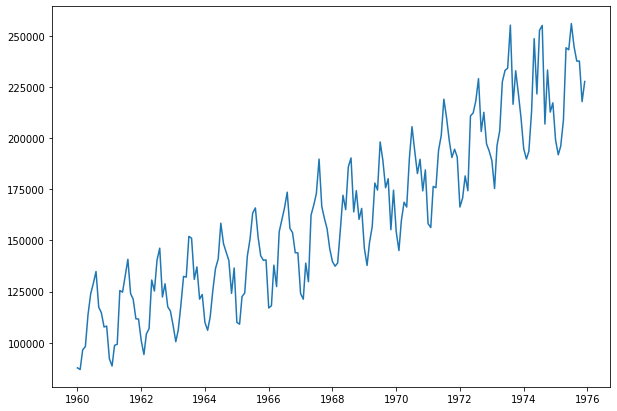

In [143]:
plt.plot(data)

### Time series decomposition

The decomposition of time series is a statistical method to deconstruct time series into its trend, seasonal and residual components.

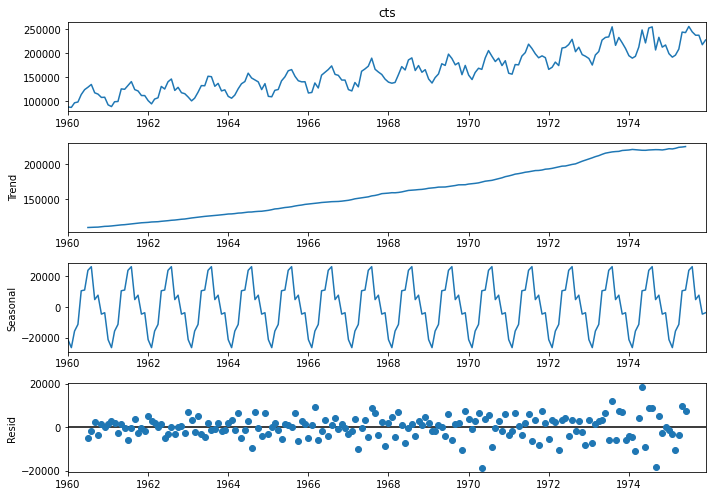

In [144]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['cts'])
decomposition.plot()
plt.show()

The decomposition plot indicates that the XX has an increasing trend and seasonal pattern.

## Check stationarity

### ACF and PACF plots

C:\Users\17606\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


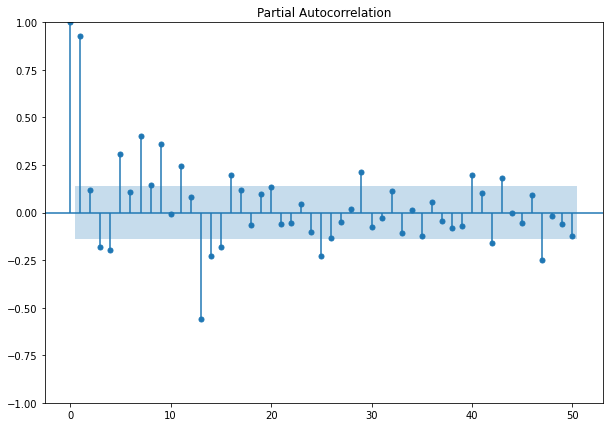

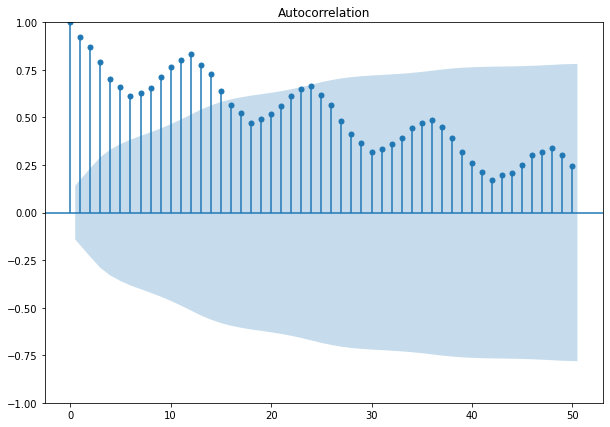

In [145]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(data, lags=50);
plot_acf(data, lags=50);

Both ACF and PACF plots do not show a quick cut off into the 95% confidence interval area (in blue) meaning time series is not stationary.

### Testing stationarity

#### Augmented Dickey-Fuller test

In [146]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data['cts'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   0.584705
p-value                          0.987232
#Lags Used                      15.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


The null hypothesis of the test is time series has a unit root, meaning that it is non-stationary. The results show that p-value is greater than 0.05 (level alpha), we fail to reject the null hypothesis and time series is non-stationary.

## Make data stationary

In [147]:
df_log = np.log(data)

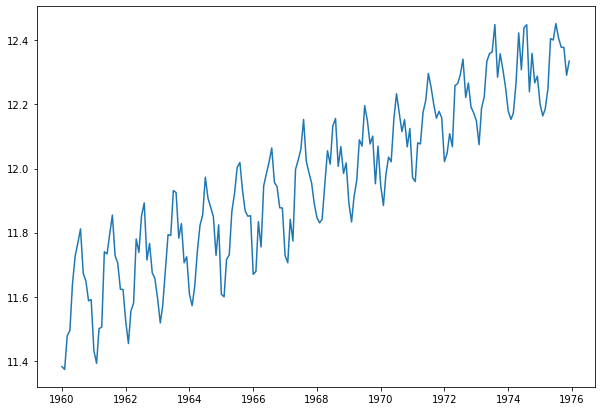

In [148]:
plt.plot(df_log)

In [149]:
df_diff = df_log.diff().diff(12).dropna()

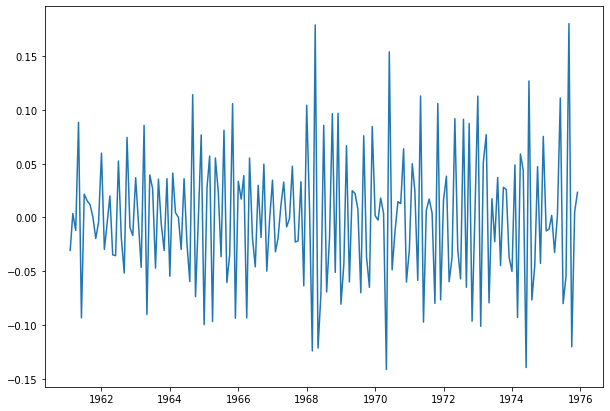

In [150]:
plt.plot(df_diff)

C:\Users\17606\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


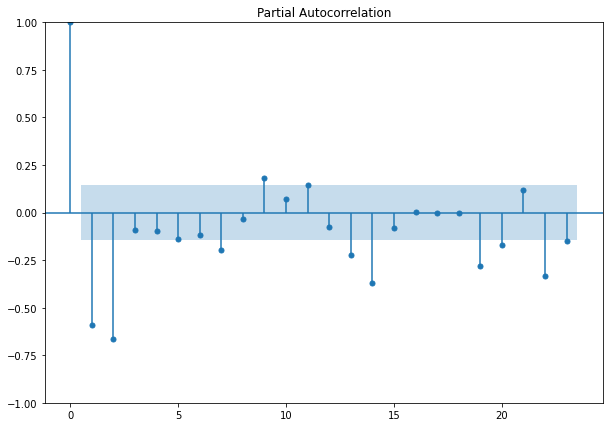

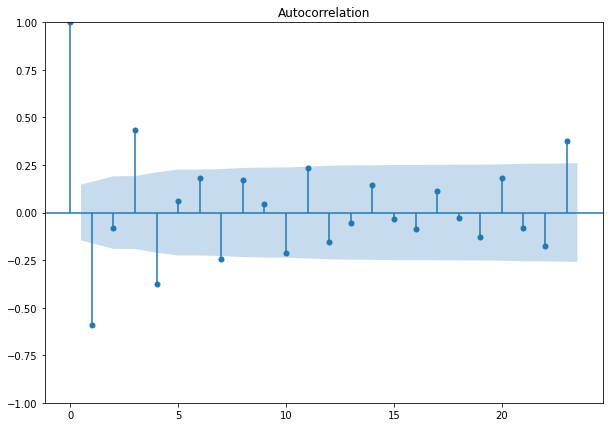

In [151]:
plot_pacf(df_diff);
plot_acf(df_diff);

In [152]:
dftest = adfuller(df_diff['cts'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -5.872225e+00
p-value                        3.220210e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.650000e+02
Critical Value (1%)           -3.470616e+00
Critical Value (5%)           -2.879221e+00
Critical Value (10%)          -2.576197e+00
dtype: float64


P-value almost 0.00, which is lower than the threshold. All these checks suggest that differenced data is stationary now.

## Modeling: SARIMA

SARIMA models are denoted with the order of SARIMA(p, d, q)(P, D, Q)m

### Model Prameter Estimiation

We will use Python’s pmdarima library, to automatically extract the best parameters for our Seasonal ARIMA model. This helps us to determine the best parameters by comparing the AIC scores.

In [153]:
import pmdarima as pm
model = pm.auto_arima(df_diff, d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-113.450, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-238.514, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-212.563, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-251.282, Time=0.70 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.42 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-155.226, Time=0.82 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-416.646, Time=1.56 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-392.687, Time=0.31 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.76 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-459.418, Time=1.70 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-432.8

The result of auto_arima function with various (p, d, q)(P, D, Q)m parameters indicates that the lowest AIC score is obtained when the parameters equal to (4, 1, 2)(2, 1, 1)[12].

### Fitting model on training data

In [154]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(data['cts'],
                order=(4,1,2),seasonal_order=(2,1,1,12))
results = model.fit()
results.summary()

C:\Users\17606\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\17606\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\17606\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\17606\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA pa

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  cts   No. Observations:                  192
Model:             SARIMAX(4, 1, 2)x(2, 1, [1], 12)   Log Likelihood               -1863.827
Date:                              Mon, 17 Oct 2022   AIC                           3747.654
Time:                                      20:25:49   BIC                           3779.528
Sample:                                  01-01-1960   HQIC                          3760.578
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0341      0.425      0.080      0.936      -0.800       0.868
ar.L2          0.2188      0.395      0.554      0.580      -0.556       0.993
ar.L3          0.3168      0.164      1.937      0.053      -0.004       0.637
ar.L4         -0.1942      0.075     -2.590      0.010      -0.341      -0.047
ma.L1         -0.4445      0.443     -1.003      0.316      -1.313       0.424
ma.L2         -0.1756      0.258     -0.682      0.495      -0.680       0.329
ar.S.L12       0.3302      0.079      4.179      0.000       0.175       0.485
ar.S.L24      -0.0894      0.040     -2.217      0.027      -0.168      -0.010
ma.S.L12      -0.7119      0.079     -9.016      0.000      -0.867      -0.557
sigma2      4.345e+07   3.41e-08   1.28e+15      0.000    4.35e+07    4.35e+07
===================================================================================
Ljung-Box (L1) (Q):                  13.64   Jarque-Bera (JB):                16.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.36
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.37e+31. Standard errors may be unstable.
"""

### prediction of training

In [155]:
fitted_values = results.fittedvalues
fitted_values

month
1960-01-01         0.000000
1960-02-01     53063.232383
1960-03-01     66964.075204
1960-04-01    113707.740559
1960-05-01     83735.008557
                  ...      
1975-08-01    261618.956187
1975-09-01    216588.622197
1975-10-01    240755.226171
1975-11-01    222346.847976
1975-12-01    231713.751951
Length: 192, dtype: float64

## Model Validation

In [156]:
model = SARIMAX(data['cts'],
                order=(4,1,2),seasonal_order=(2,1,1,12))
results = model.fit()
results.summary()

C:\Users\17606\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\17606\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\17606\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\17606\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA pa

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  cts   No. Observations:                  192
Model:             SARIMAX(4, 1, 2)x(2, 1, [1], 12)   Log Likelihood               -1863.827
Date:                              Mon, 17 Oct 2022   AIC                           3747.654
Time:                                      20:25:51   BIC                           3779.528
Sample:                                  01-01-1960   HQIC                          3760.578
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0341      0.425      0.080      0.936      -0.800       0.868
ar.L2          0.2188      0.395      0.554      0.580      -0.556       0.993
ar.L3          0.3168      0.164      1.937      0.053      -0.004       0.637
ar.L4         -0.1942      0.075     -2.590      0.010      -0.341      -0.047
ma.L1         -0.4445      0.443     -1.003      0.316      -1.313       0.424
ma.L2         -0.1756      0.258     -0.682      0.495      -0.680       0.329
ar.S.L12       0.3302      0.079      4.179      0.000       0.175       0.485
ar.S.L24      -0.0894      0.040     -2.217      0.027      -0.168      -0.010
ma.S.L12      -0.7119      0.079     -9.016      0.000      -0.867      -0.557
sigma2      4.345e+07   3.41e-08   1.28e+15      0.000    4.35e+07    4.35e+07
===================================================================================
Ljung-Box (L1) (Q):                  13.64   Jarque-Bera (JB):                16.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.36
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.37e+31. Standard errors may be unstable.
"""

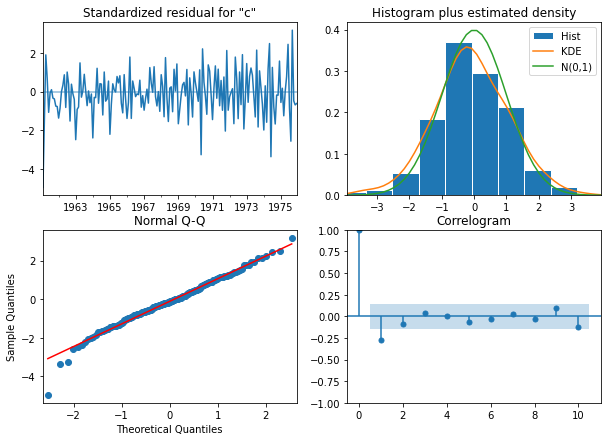

In [157]:
results.plot_diagnostics()
plt.show()

The top-left plot shows the residuals over time and it appears to be a white noise with no seasonal component.

The top-right plot shows that kernel density estimation (KDE) line closely follows the standard normal distribution N(0,1) line, suggesting the residuals are normally distributed.

The bottom-left normal QQ-plot shows that we almost have a straight line, suggesting residuals are normally distributed.

The bottom-right is a correlogram plot indicating there is low autocorrelation in the residuals.

## Forecast and Plot

In [158]:
# forecast 20 steps ahead
forecast = results.get_forecast(steps=20)
forecast_value = forecast.predicted_mean
forecast_value

1976-01-01    201117.996602
1976-02-01    198983.687598
1976-03-01    207994.873866
1976-04-01    213985.015311
1976-05-01    247869.572108
1976-06-01    247466.462390
1976-07-01    259045.487159
1976-08-01    255701.600363
1976-09-01    240695.427694
1976-10-01    243948.849978
1976-11-01    227597.529152
1976-12-01    232547.953654
1977-01-01    210454.334578
1977-02-01    207027.736855
1977-03-01    216883.758127
1977-04-01    223738.642614
1977-05-01    254724.324642
1977-06-01    253043.413659
1977-07-01    266276.597315
1977-08-01    265725.092051
Freq: MS, Name: predicted_mean, dtype: float64

In [159]:
# CI of the forecasted values
CI = forecast.conf_int()
CI

,lower cts,upper cts
1976-01-01,188198.109497,214037.883706
1976-02-01,183985.306045,213982.069151
1976-03-01,190998.744972,224991.002759
1976-04-01,193771.863751,234198.166871
1976-05-01,226499.827248,269239.316968
1976-06-01,224434.041918,270498.882861
1976-07-01,234448.509504,283642.464814
1976-08-01,230085.058961,281318.141765
1976-09-01,213731.649763,267659.205624
1976-10-01,215871.974243,272025.725714


In [160]:
forecast.summary_frame()

cts,mean,mean_se,mean_ci_lower,mean_ci_upper
1976-01-01,201117.996602,6591.900263,188198.109497,214037.883706
1976-02-01,198983.687598,7652.376100,183985.306045,213982.069151
1976-03-01,207994.873866,8671.653677,190998.744972,224991.002759
1976-04-01,213985.015311,10313.021933,193771.863751,234198.166871
1976-05-01,247869.572108,10903.131399,226499.827248,269239.316968
1976-06-01,247466.462390,11751.450870,224434.041918,270498.882861
1976-07-01,259045.487159,12549.708999,234448.509504,283642.464814
1976-08-01,255701.600363,13069.904143,230085.058961,281318.141765
1976-09-01,240695.427694,13757.282350,213731.649763,267659.205624
1976-10-01,243948.849978,14325.199829,215871.974243,272025.725714


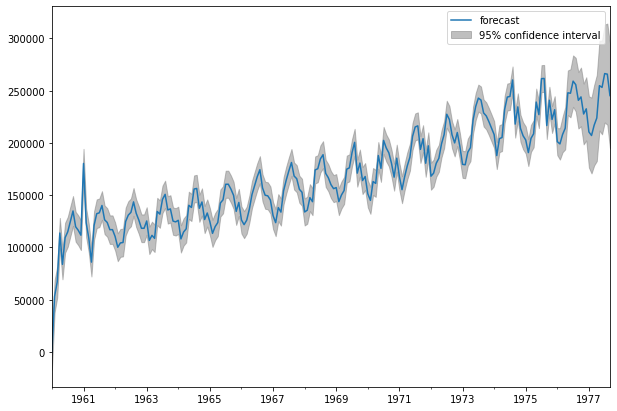

In [161]:
from statsmodels.graphics.tsaplots import plot_predict

plot_predict(results,start=0, end=data.shape[0] + 20);
#plt.plot(data['cts'], label='actual')
#plt.show()

### Plot the predictions

C:\Users\17606\AppData\Local\Temp\ipykernel_22400\3897249984.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast = data['arima_model'].append(forecast)


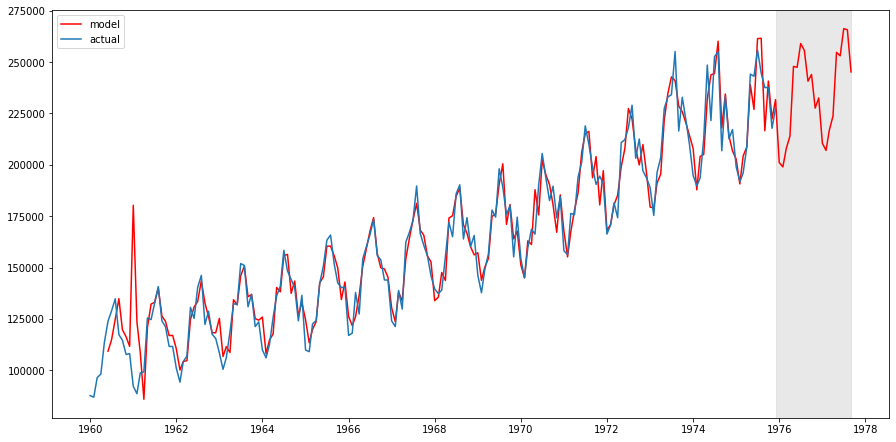

In [162]:
data['arima_model'] = results.fittedvalues
data['arima_model'][:4+1] = np.NaN
forecast = results.predict(start=data.shape[0], end=data.shape[0] + 20)
forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['cts'], label='actual')
plt.legend()
plt.show()